In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
from rich import print as pprint
from sourcesep.utils.config import load_config

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData
paths = load_config(dataset_key='all')
sim = SimData(T=10000, cfg_path=paths['root'] / "sim_HSFP_670128_2023-04-27.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     445     473     514     560
EGFP  0.1732  0.3915  0.8143  0.1469  0.0054

In [3]:
paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'HSFP_670128_2023-04-27_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
for j in np.argsort(f['Lasers'][:]):
    xj[j]  = f[f'Channel{j+1}'][:].astype(float)

t = f['Time'][:]
l = f['Wavelength'][:]
lasers = f['Lasers'][:][np.argsort(f['Lasers'][:])]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Channel4', 'Channel5', 'Lasers', 'Time', 'Wavelength']>

sampling frequency: 23.99 Hz
length of recording: 448.23 seconds

each channel has dimensions of (10752, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


In [4]:
# Normalizing data with respect to the mean of each pixel
rel_xj = {}
mean_per_px = {}
for j in range(len(xj)):
    mean_per_px[j] = np.mean(xj[j], axis=0, keepdims=True)
    rel_xj[j] = xj[j]/mean_per_px[j]

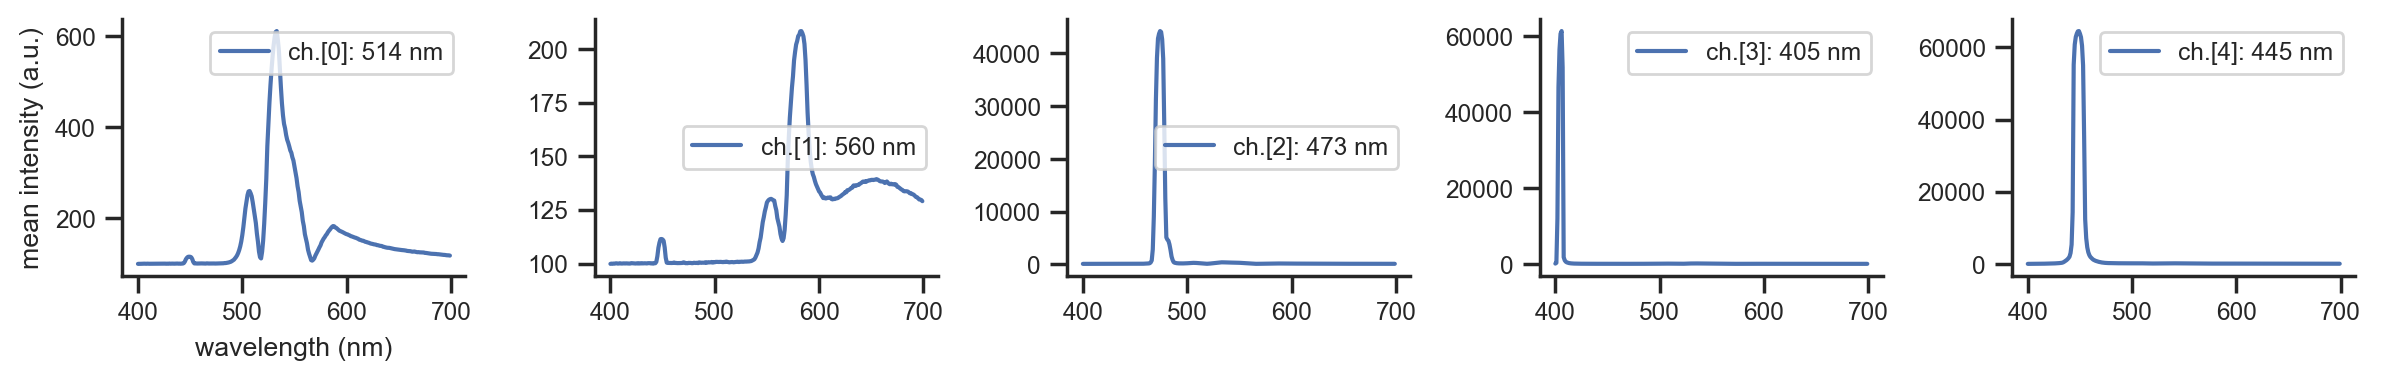

In [5]:
f, ax = plt.subplots(1, 5, figsize=(12, 2))
lasers_inferred = [514,560, 473, 405, 445]
for j in range(len(xj)):
    ax[j].plot(l, np.squeeze(mean_per_px[j]), label=f'ch.[{j}]: {lasers_inferred[j]} nm')
    ax[j].legend()
    if j == 0:
        ax[j].set(xlabel = 'wavelength (nm)', ylabel = 'mean intensity (a.u.)')

plt.tight_layout()
plt.show()

#plot the same with plotly for interactivity
# import plotly.graph_objects as go
# fig = go.Figure()
# for j in range(len(xj)):
#     fig.add_trace(go.Scatter(x=l, y=np.squeeze(mean_per_px[j]), name=f'ch.[{j}]: {lasers_inferred[j]} nm'))
# fig.update_layout(  xaxis_title="wavelength (nm)",
#                     yaxis_title="mean intensity (a.u.)",
#                     legend_title="Channel")
# fig.show()

In [22]:
# The following were inferred from the above plots to determine initialization for laser time series
roi_laser = [(495,515), 
              (545,563), 
              (468,479), 
              (402,409), 
              (443,455)]

for j in range(len(roi_laser)):
    roi_laser[j] = np.where(np.logical_and(l>roi_laser[j][0], l<roi_laser[j][1]))[0]

roi_indicator = np.where(np.logical_and(l>530, l<540))[0]

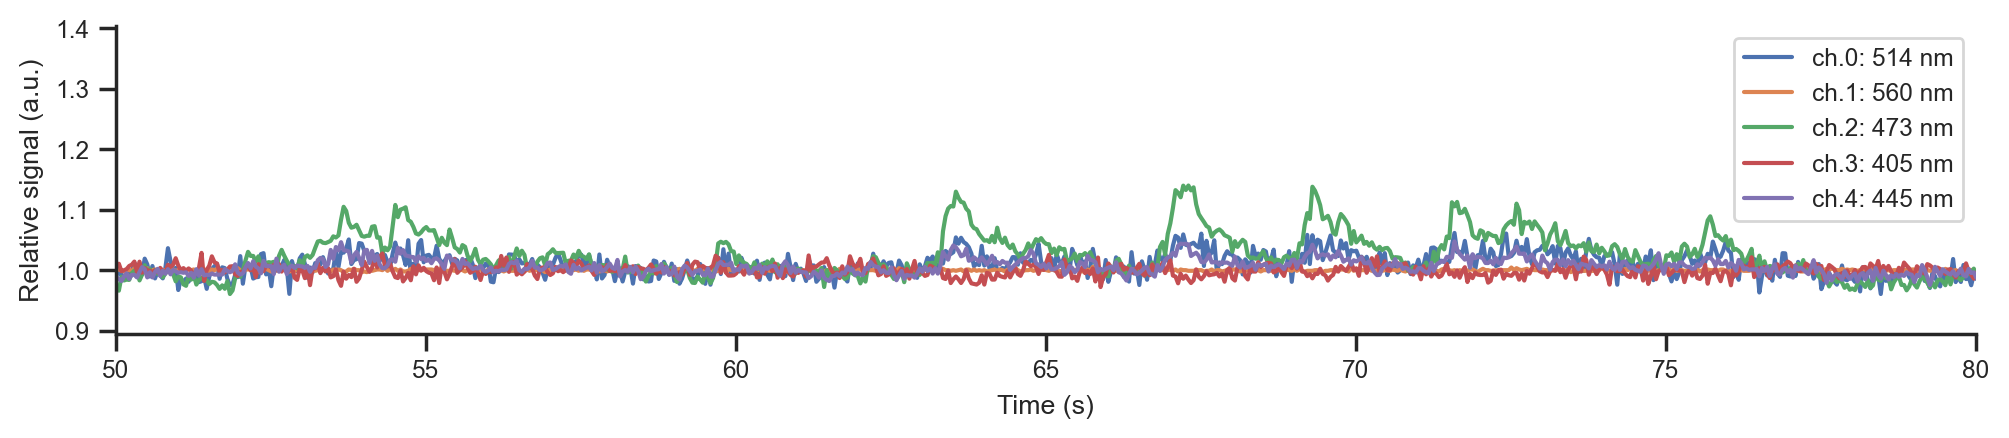

In [23]:
# show indicator roi in different channels

f, ax = plt.subplots(1,1,figsize = (12,2))
for j in range(5):
    avg_roi_rel = np.mean(rel_xj[j][:,roi_indicator], axis=1).squeeze()
    ax.plot(t, avg_roi_rel, label=f'ch.{j}: {lasers_inferred[j]} nm')
    ax.set(xlim = (50, 80), xlabel = 'Time (s)', ylabel = 'Relative signal (a.u.)')
plt.legend()
plt.show()

In [24]:
avg_signal_laser = {}
for j in range(len(roi_laser)):
    avg_signal_laser[j] = np.mean(rel_xj[j][:,roi_laser[j]], axis=1).squeeze()

avg_signal_indicator = np.mean(rel_xj[2][:,roi_indicator], axis=1).squeeze()

In [36]:
sources = [*[avg_signal_laser[j] for j in range(5)], avg_signal_indicator]
corr = np.corrcoef(sources)
pprint(np.round(corr, 2))

# It seems like the filter is blocking out the 514 nm laser such that 
# away from the laser wavelength, the signal is dominated by the indicator signal.
# We'll correct it by subtracting the projection of the indicator signal from the laser signal.



[[1.   0.06 0.04 0.07 0.05 0.86]
 [0.06 1.   0.   0.03 0.01 0.05]
 [0.04 0.   1.   0.03 0.13 0.25]
 [0.07 0.03 0.03 1.   0.04 0.06]
 [0.05 0.01 0.13 0.04 1.   0.05]
 [0.86 0.05 0.25 0.06 0.05 1.  ]]

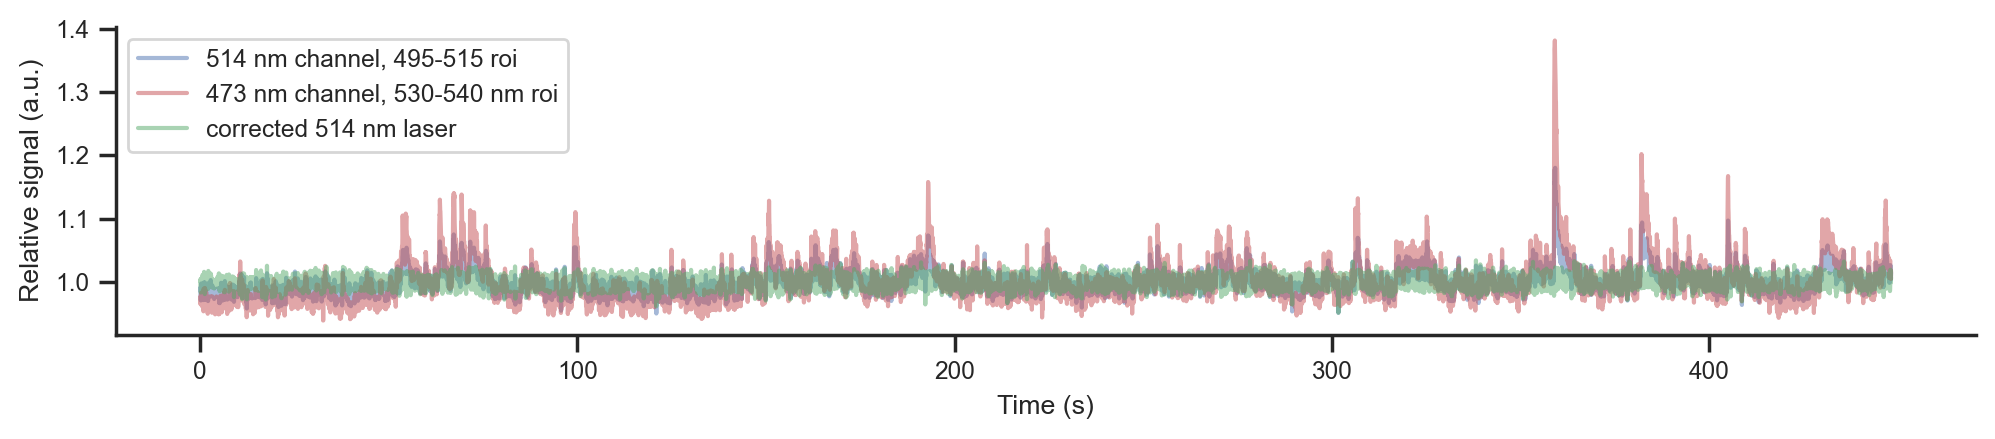

Correlation coef: 0.865

In [56]:
a = np.copy(avg_signal_laser[0])
b = np.copy(avg_signal_indicator)
a_avg = np.mean(a)
b_avg = np.mean(b)
a = a - a_avg
b = b - b_avg
uncorr_laser_src = (a - np.dot(a,b)/np.dot(b,b) * b) + a_avg

f, ax = plt.subplots(1,1,figsize = (12,2))
ax.plot(t, np.squeeze(avg_signal_laser[0]), 'b', alpha=0.5, label='514 nm channel, 495-515 roi')
ax.plot(t, np.squeeze(avg_signal_indicator), 'r', alpha=0.5, label='473 nm channel, 530-540 nm roi')
ax.plot(t, np.squeeze(uncorr_laser_src), 'g', alpha=0.5, label='corrected 514 nm laser')
ax.set(xlabel='Time (s)', ylabel='Relative signal (a.u.)')
plt.legend()
plt.show()

pprint(f'Correlation coef: {np.corrcoef(np.squeeze(avg_signal_laser[0]), np.squeeze(avg_signal_indicator))[1,0]:0.03f}')

In [59]:
sources[0] = uncorr_laser_src

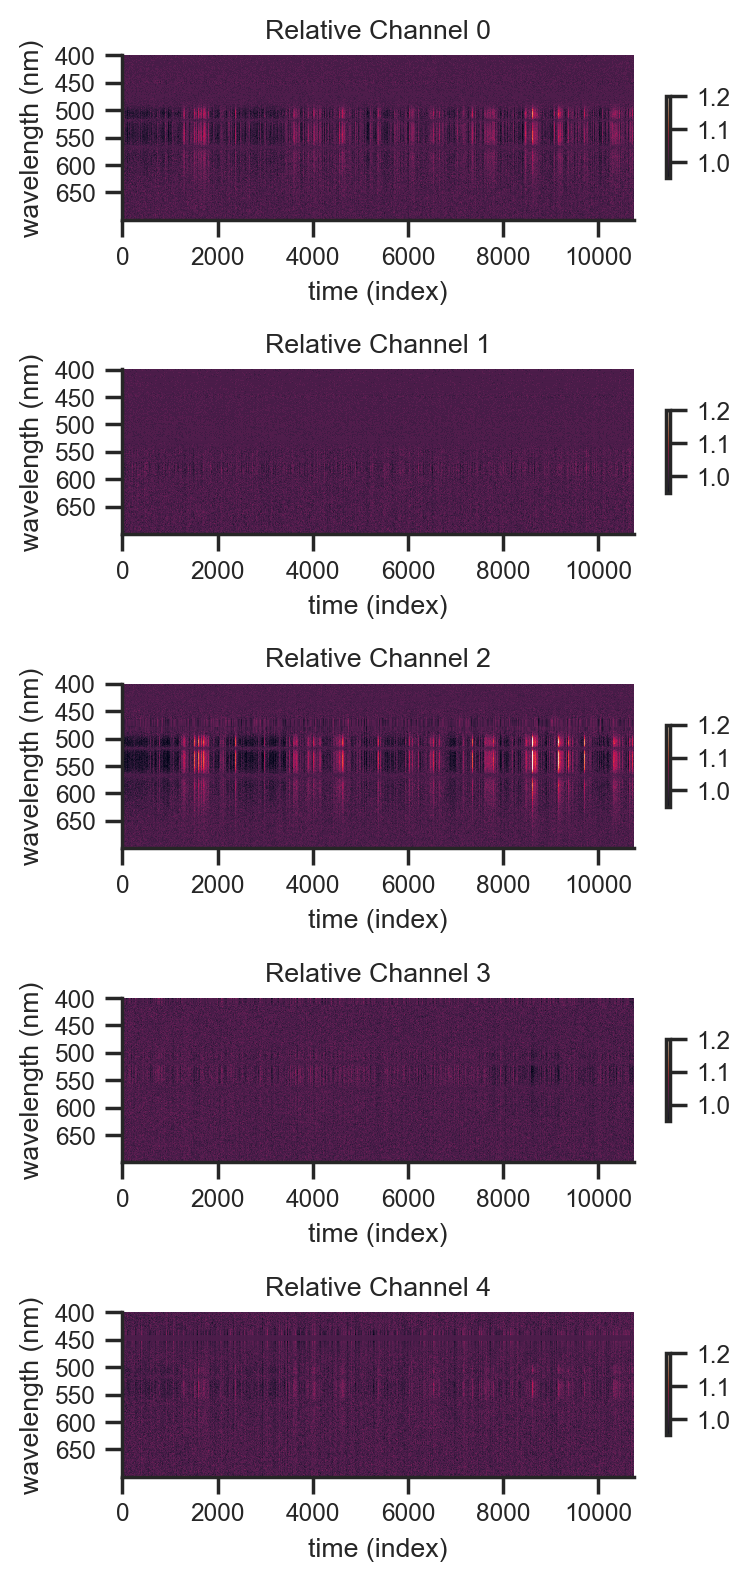

In [60]:
# Check normalized data across different channels
f, ax = plt.subplots(5, 1, figsize=(4, 8))
for j in range(5):
    f.colorbar(ax[j].imshow(rel_xj[j].T, interpolation='nearest', aspect='auto', vmin=0.95, vmax=1.2), ax=ax[j], shrink=0.5)
    ax[j].grid(visible=False)
    ax[j].set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Relative Channel {j}')
    ax[j].set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

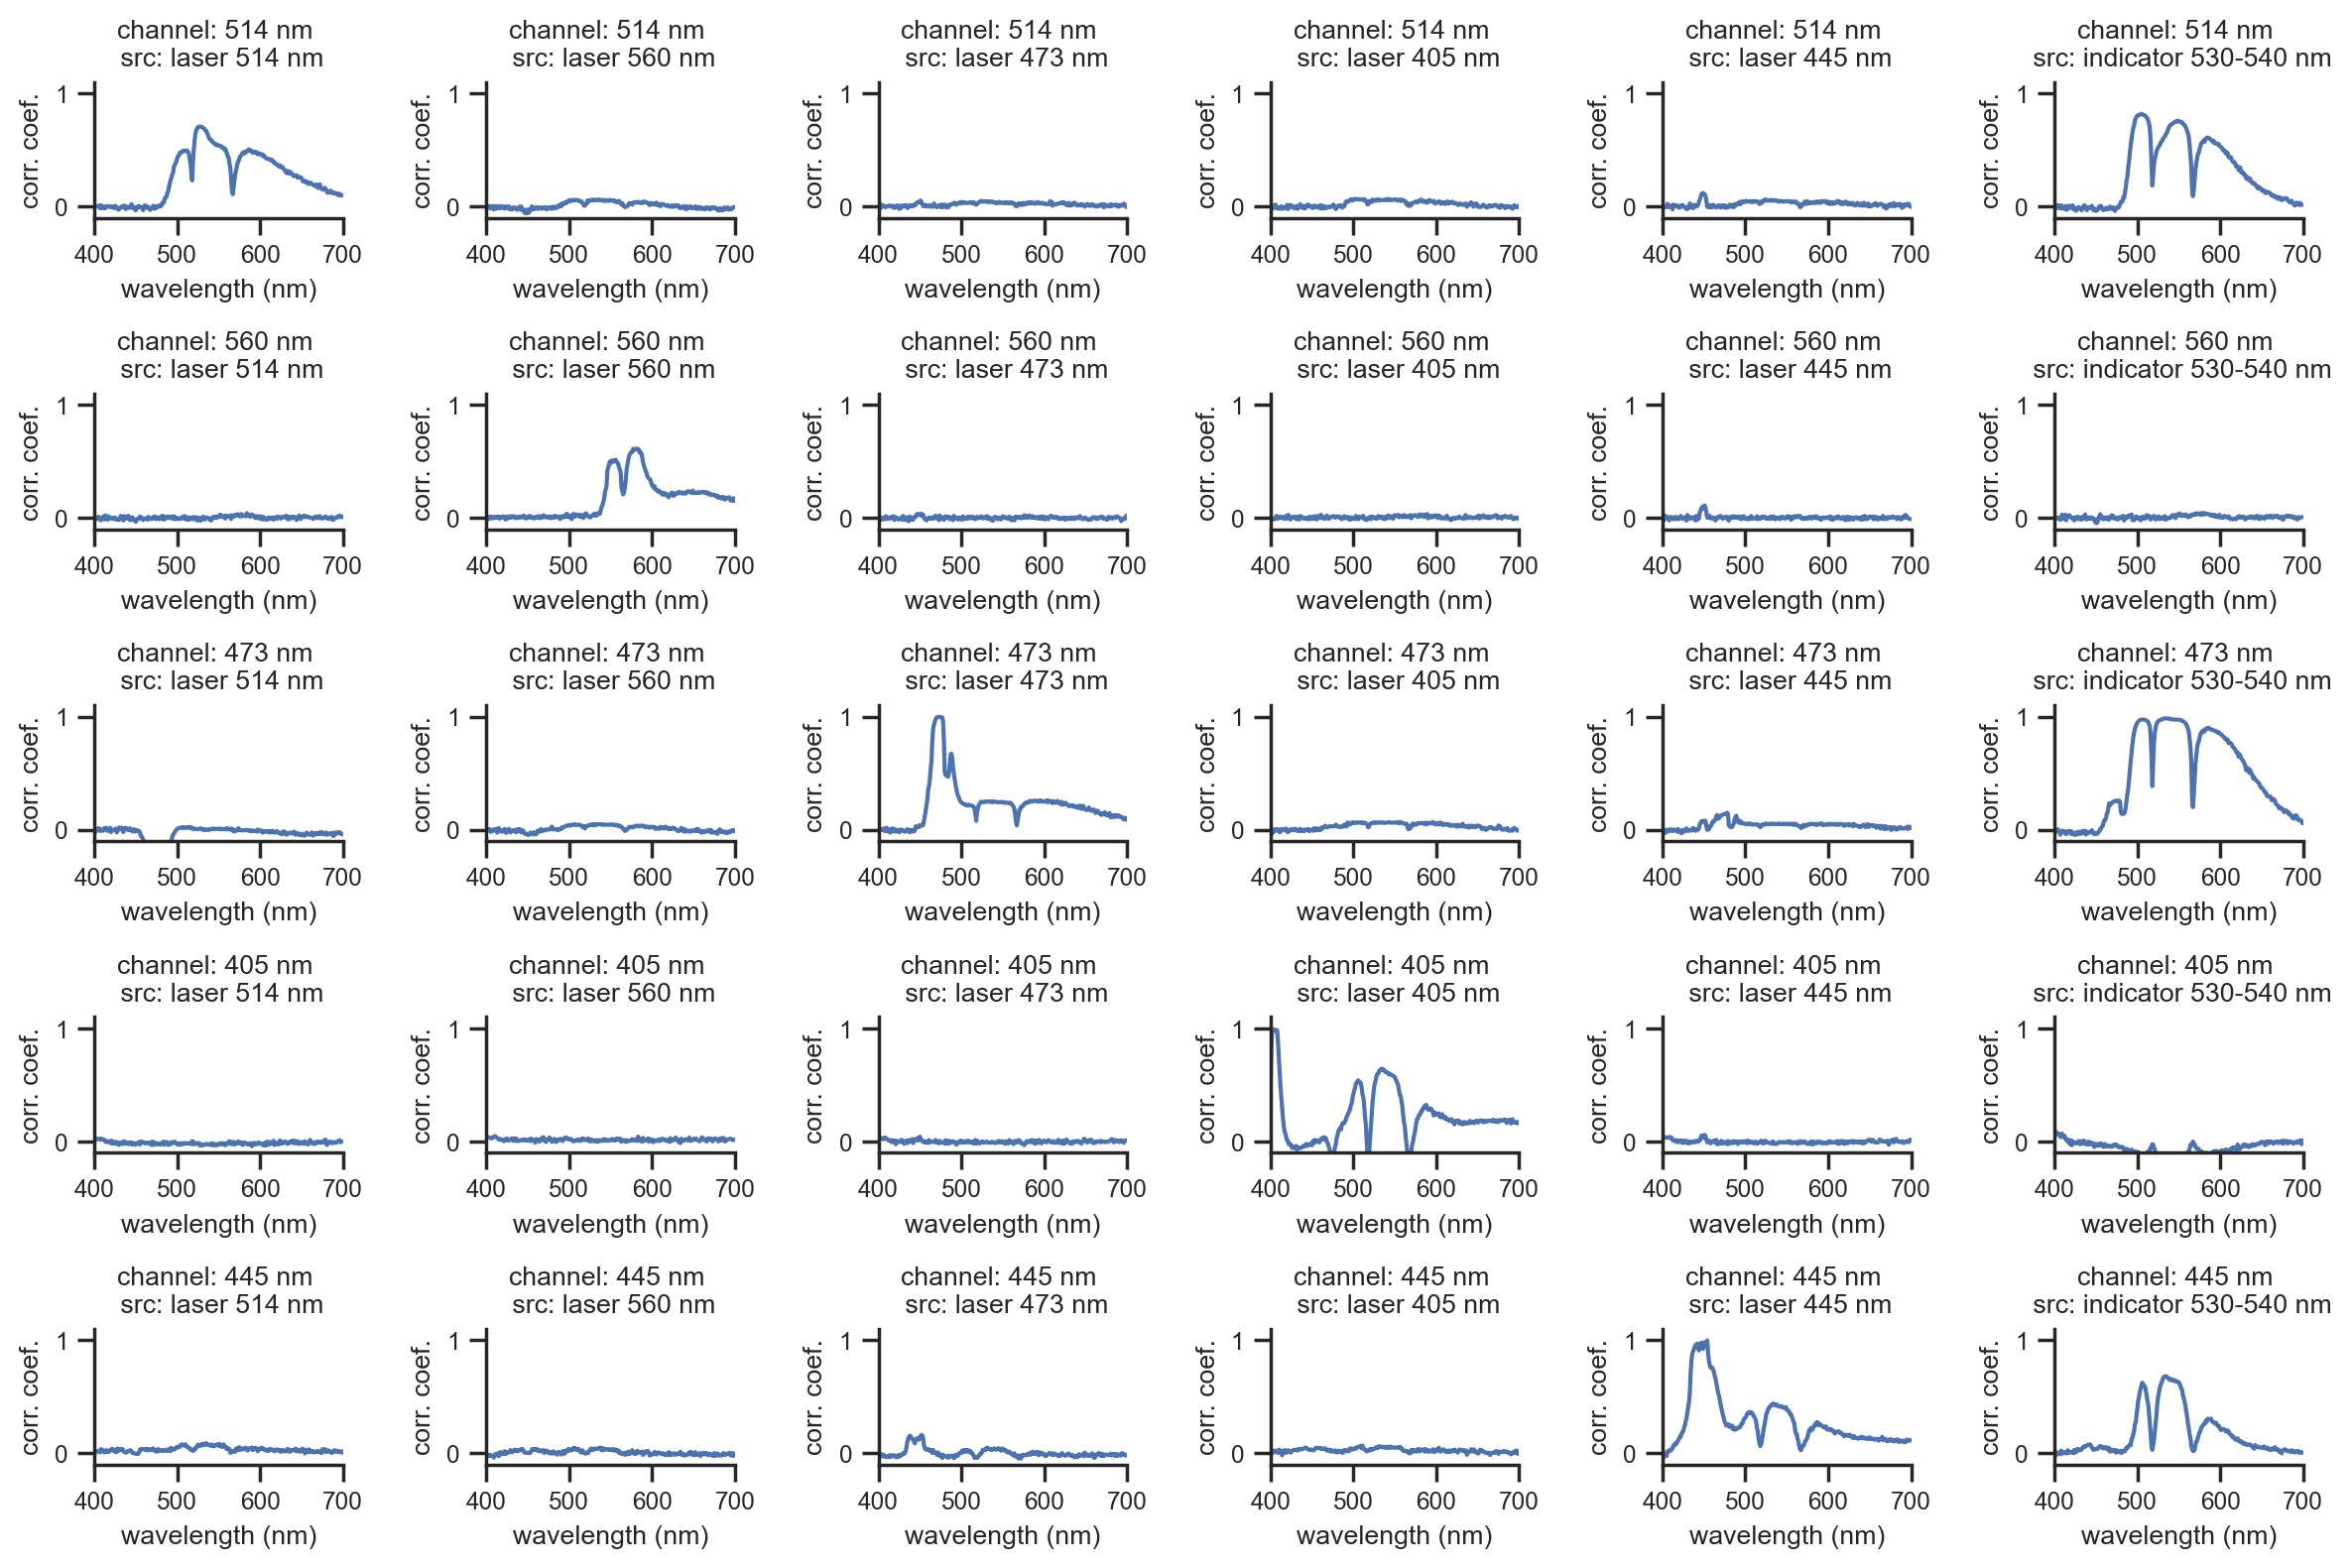

In [61]:
# for each source, plot the correlation at each pixel in each channel. There will be channels x sources number of plots.

def coef_fn(x,y):
    c = np.dot(x - np.mean(x), y - np.mean(y)) / np.size(x)
    c = c / (np.std(x)*np.std(y) + 1e-10)
    return c

src_label = ['laser 514 nm', 'laser 560 nm', 'laser 473 nm', 'laser 405 nm', 'laser 445 nm', 'indicator 530-540 nm']

f, ax = plt.subplots(len(lasers), len(sources), figsize=(12, 8))
for col,src in enumerate(sources):
    for j in range(5):
        src_cc = np.array([coef_fn(src, rel_xj[j][:,px]) for px in range(rel_xj[j].shape[1])])
        ax[j,col].plot(l,src_cc, '-b')
        ax[j,col].set(xlim=(400, 700),
            ylim=(-0.1, 1.1),
            title=f'channel: {lasers_inferred[j]} nm \n src: {src_label[col]}',
            xlabel='wavelength (nm)',
            ylabel='corr. coef.',)
        #ax[j,col].legend(bbox_to_anchor=(1.00, 1.00), loc='upper left')
plt.tight_layout()
plt.show()


#### Correlation of laser noise for pixels at diffferent wavelengths:

In [ ]:
# scaled signals do not affect the correlation coefficients
laser_cc_rel = np.array([coef_fn(laser_noise_rel, rel_xj[2][:,i]) for i in range(rel_xj[2].shape[1])])
indicator_cc_rel = np.array([coef_fn(avg_roi_rel, rel_xj[2][:,i]) for i in range(rel_xj[2].shape[1])])
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l,laser_cc_rel, '-b', label='Rel. Laser Noise corr')
ax.plot(l,indicator_cc_rel, '-r', label='Rel. Indicator roi corr')
ax.set(xlim=(400, 700),
       ylim=(-0.1, 1.1),
       xlabel='Pixel ~ Wavelength (nm)',
       ylabel='Pearson corr. coeff.',)
ax.legend(bbox_to_anchor=(1.00, 1.00), loc='upper left')
plt.show()


In [ ]:
# For the relative signal, What is the regression coefficient for laser noise?

def project(y, x):
    return np.dot(y, x) / np.dot(x, x)

laser_proj_rel = np.array([project(laser_noise_rel, rel_xj[2][:,i]) for i in range(rel_xj[2].shape[1])])
indicator_proj_rel = np.array([project(avg_roi_rel, rel_xj[2][:,i]) for i in range(rel_xj[2].shape[1])])

f, ax = plt.subplots(1, 2, figsize=(6, 2))
ax[0].plot(l,laser_proj_rel, '-b', label='Rel. Laser Noise coef')
ax[0].set(xlim=(400, 700),
       xlabel='Pixel ~ Wavelength (nm)',
       ylabel='Contrib of laser noise',)

ax[1].plot(l,indicator_proj_rel, '-r', label='Rel. Indicator roi coef')
ax[1].set(xlim=(400, 700),
       xlabel='Pixel ~ Wavelength (nm)',
       ylabel='Contrib of indicator signal',)
plt.tight_layout()
plt.show()


We assume that the signal at each measured wavelength ${\lambda}$ is a linear combination of laser noise $h_0$ and indicator activity $h_1$.
$$ x^{\lambda}(t) = w^{\lambda}_0 h_0(t) + w^{\lambda}_1 h_1(t) $$

 - $h_0(t)$ can be initialized via the raw signal around `473 nm`.
 - $h_1(t)$ can be initialized via the raw signal around `530 nm`.
 - $ w^{\lambda}_0 $ init. as corr. coef. of laser roi with the signal at each wavelength (pixel).
 - $ w^{\lambda}_1 $ init. as corr. coef. of indicator roi with the signal at each wavelength (pixel).
<p></p>

 - In the raw signal, laser noise is orders of magnitude larger than indicator activity.
 - Normalization is necessary signal at each pixel is important (e.g. by avg signal over time at the pixel)\

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
plt.plot(l, np.mean(xj[2], axis=0).squeeze(), '-k', label='Average signal')
plt.plot(sim.L_arr, 100+1500*sim.S.squeeze(), '-r', label='scaled EGFP em. spectrum')
plt.plot(l, 1000*laser_cc, '-g', label='scaled laser noise corrcoef')
ax.set(xlim=(400, 700),
       ylim=(0, 2000),
       xlabel='Wavelength (nm)',
       ylabel='Intensity (a.u.)')
ax.legend()
plt.show()


In [ ]:
# For the df/f signal, the average is at 1.0 (black line)!
f, ax = plt.subplots(1, 1, figsize=(4, 2))
plt.plot(l, np.mean(rel_xj[2], axis=0).squeeze(), '-k', label='Average rel. signal')
plt.plot(sim.L_arr, sim.S.squeeze(), '-r', label='scaled EGFP em. spectrum')
plt.plot(l, laser_cc_rel, '-g', label='laser noise corrcoef')
ax.set(xlim=(400, 700),
       ylim=(-0.1, 1.2),
       xlabel='Wavelength (nm)',
       ylabel='Intensity (a.u.)')
ax.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(4, 2))
plt.plot(l, np.mean(xj[2], axis=0).squeeze(), '-k', label='Average signal')
plt.plot(sim.L_arr, 100+1500*sim.S.squeeze(), '-r', label='scaled EGFP em. spectrum')
plt.plot(l, 1000*laser_cc, '-g', label='scaled laser noise corrcoef')
ax.set(xlim=(400, 700),
       xlabel='Wavelength (nm)',
       ylabel='Intensity (a.u.)')
ax.legend()
plt.show()

In [ ]:
# Heuristically setting spectrum for EGFP and laser in region of overlap
# These will become our initial guesses for the response. 
# Issues with calibration of wavelengths, notch shape etc. is sidestepped for now.

S_composite = np.mean(xj[2], axis=0).squeeze()

fun0 = lambda x: S_composite[l==487]*np.exp(-(x-487)/2) + 100
x = np.arange(487,700)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l[l < 500], S_composite[l < 500], '-b')
ax.plot(x, fun0(x), '-r')
ax.set(xlim=(400, 700), ylim=(0, 800),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
plt.show()

fun1 = lambda x: np.exp((x-452)/10) + 100
x = np.arange(400,502)

f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l[l > 500], S_composite[l > 500], '-b')
ax.plot(x, fun1(x), '-r')
ax.plot(l[l < 455], S_composite[l < 455], '-b')
ax.set(xlim=(400, 700), ylim=(0, 400),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
plt.show()

w_0 = np.concatenate([S_composite[l < 487], fun0(l[l >= 487])])
w_1 = np.concatenate([S_composite[l < 455],
                      fun1(l[np.logical_and(l >= 455, l <= 500)]),
                      S_composite[l > 500]])
f, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(l, w_0, '-b', label='w0')
ax.plot(l, w_1, '-r', label='w1')
ax.plot(l, S_composite, '-k', alpha=0.5, label='Composite')
ax.set(xlim=(400, 700), ylim=(0, 400),
       xlabel='Wavelength (nm)', ylabel='Intensity (a.u.)')
ax.legend()
plt.show()


#### NMF with the raw signal

In [ ]:

X = xj[2]
avg_signal = np.mean(X,axis=0)
X = X/avg_signal.reshape(1,-1)
print('X', X.shape)

W_init = np.vstack((laser_cc.reshape(1,-1),indicator_cc.reshape(1,-1)))
W_init = W_init+ 0.2
print('W_init', W_init.shape)

H_init = np.hstack((X[:,l==473].reshape(-1,1),X[:,l==530].reshape(-1,1)))
H_init = H_init/np.mean(H_init,axis=1, keepdims=True)
print('H_init', H_init.shape)

In [ ]:
import numpy as np
from sklearn.decomposition import NMF

idx_start = 0
idx_end = 2000
n_components = 2
model = NMF(n_components=n_components, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

In [ ]:
W_fit = model.fit_transform(X.T[:,idx_start:idx_end], W=W_init.T, H=H_init.T[:,idx_start:idx_end])
H_fit = model.components_

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(t[idx_start:idx_end], H_fit.T)
ax[0].set(xlabel='Time (s)')

ax[1].plot(l, W_fit)
ax[1].set(xlabel='Wavelength (nm)')
plt.show()

In [ ]:
f,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(l,xj[2].std(0).squeeze())
ax.set(ylim = (0,500))

#### NMF with the relative signal (df/f)

In [ ]:
X = rel_xj[2].copy()
print('X', X.shape)

# W_init = np.vstack((laser_cc_rel.reshape(1,-1),indicator_cc_rel.reshape(1,-1)))
# W_init = W_init + 0.2
# print('W_init', W_init.shape)

EPS = 0.00001
W_init = np.vstack((laser_proj_rel.reshape(1,-1),indicator_proj_rel.reshape(1,-1)))
W_init[W_init<EPS] = EPS
print('W_init', W_init.shape)

H_init = np.hstack((X[:,l==473].reshape(-1,1),X[:,l==530].reshape(-1,1))) # Initialized with particular channels
print('H_init', H_init.shape)

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(H_init[:,0],'-r',alpha=0.5, label='component 0')
ax.plot(H_init[:,1],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='H')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(W_init[0,:]+1,'-r',alpha=0.5, label='component 0')
ax.plot(W_init[1,:],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='W')
ax.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import NMF

idx_start = 6000
idx_end = 10000
n_components = 2
model = NMF(n_components=n_components, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-11, max_iter=100000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

In [ ]:
X_ = X.T.copy()
W_ = W_init.T.copy()
H_ = H_init.T.copy()

X_ = X_[:,idx_start:idx_end]
H_ = H_[:,idx_start:idx_end]
print(X_.shape, W_.shape, H_.shape)

In [ ]:
W_fit = model.fit_transform(X_.copy(), W=W_.copy(), H=H_.copy())
H_fit = model.components_
print(W_fit.shape)
print(H_fit.shape)

In [ ]:
res = X_ - W_fit @ H_fit
print(f'Avg Frobenius norm (error): {np.mean(res**2):0.7f}')

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))
f.colorbar(ax.imshow(res, interpolation='nearest', aspect='auto'), ax=ax, shrink=0.5)
ax.grid(visible=False)
ax.set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Residuals')
ax.set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
plt.show()

f, ax = plt.subplots(1, 1, figsize=(6, 3))
f.colorbar(ax.imshow(X.T, interpolation='nearest', aspect='auto'), ax=ax, shrink=0.5)
ax.grid(visible=False)
ax.set(ylabel='wavelength (nm)', xlabel='time (index)', title=f'Residuals')
ax.set_yticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
plt.show()

In [ ]:
def standardize(x):
    return (x - x.mean()) / x.std()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(H_[0,:],'-r',alpha=0.5, label='component 0')
ax.plot(H_[1,:],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='H')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(H_fit[0,:],'-r',alpha=0.5, label='component 0')
ax.plot(H_fit[1,:],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='H fit')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(standardize(W_[:,0]),'-g',alpha=1, label='component 0')
ax.plot(standardize(W_[:,1]),'-b',alpha=1, label='component 1')
ax.set(xlabel='index', ylabel='W')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(standardize(W_fit[:,0]),'-g',alpha=1, label='component 0')
ax.plot(standardize(W_fit[:,1]),'-b',alpha=1, label='component 1')
ax.set(xlabel='index', ylabel='W_fit')
ax.legend()
plt.show()

In [ ]:
def standardize(x):
    return (x - x.mean()) / x.std()

# normalize and plot the component
f, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(standardize(H_[1,:]),'-b',alpha=1, label='component 1')
ax.plot(standardize(H_fit[0,:])+0.5,'-r',alpha=1, label='fit component 0')
ax.set(xlabel='index', ylabel='H fit', xlim=[0,500],ylim = [-2,4])
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(standardize(H_[0,:]),'-b',alpha=1, label='component 1')
ax.plot(standardize(H_fit[1,:])+0.5,'-r',alpha=1, label='fit component 0')
ax.set(xlabel='index', ylabel='H fit', xlim=[0,500])
ax.legend()
plt.show()

In [ ]:
def nmf_mult(X, W, H, n_steps = 5):
    for _ in range(n_steps):
        W = (W / (W @ H @ H.T)) * (X @ H.T)
        H = (H / (W.T @ W @ H)) * (W.T @ X)

    return W, H

W_fit, H_fit = nmf_mult(X_.copy(), W_.copy(), H_.copy(), n_steps=1)


f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(H_[0,:],'-r',alpha=0.5, label='component 0')
ax.plot(H_[1,:],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='H')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(H_fit[0,:],'-r',alpha=0.5, label='component 0')
ax.plot(H_fit[1,:],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='H fit')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(W_[:,0],'-r',alpha=0.5, label='component 0')
ax.plot(W_[:,1],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='W')
ax.legend()
plt.show()

f, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(W_fit[:,0],'-r',alpha=0.5, label='component 0')
ax.plot(W_fit[:,1],'-b',alpha=0.5, label='component 1')
ax.set(xlabel='index', ylabel='W_fit')
ax.legend()
plt.show()

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(t[idx_start:idx_end], H_init[idx_start:idx_end,:])
ax[0].set(xlabel='Time (s)')

ax[1].plot(l, W_init.T)
ax[1].set(xlabel='Wavelength (nm)')
plt.show()


f, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(t[idx_start:idx_end], H_fit.T)
ax[0].set(xlabel='Time (s)')

ax[1].plot(l, W_fit)
ax[1].set(xlabel='Wavelength (nm)')
plt.show()

#### Example NMF with test data

In [ ]:

from scipy.stats import norm

W_true = np.concatenate([norm.pdf(l,loc=450, scale=10).reshape(1,-1),
                    norm.pdf(l,loc=550, scale=10).reshape(1,-1)], axis = 0)

H_true = np.concatenate([np.sin(2*np.pi*0.02*t).reshape(-1,1), 
                         np.cos(2*np.pi*0.04*t).reshape(-1,1)], axis=1)
H_true = (H_true+2.1) * 0.5

f, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(l,W_true.T)
ax[0].set(xlabel='W')
ax[1].plot(t, H_true)
ax[1].set(xlabel='H', ylim = (0,2))
plt.show()

In [ ]:
X_true = H_true @ W_true
print('W_true:', W_true.shape)
print('H_true:', H_true.shape)
print('X_true:', X_true.shape)

In [ ]:
model = NMF(n_components=n_components, init='random',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=10000, random_state=None,
            alpha_W=1, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)

W_fit = model.fit_transform(X_true.T)
H_fit = model.components_

W_fit = W_fit.T
H_fit = H_fit.T

In [ ]:
f, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(l,W_true.T)
ax[0].set(xlabel='W')
ax[1].plot(t, H_true)
ax[1].set(xlabel='H', ylim = (0,2))
plt.show()

f, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(l, W_fit.T)
ax[0].set(xlabel='W_fit')
ax[1].plot(t, H_fit)
plt.show()

In [ ]:
err = np.abs((H_fit@W_fit - H_true@W_true))
pltj = [H_true@W_true,H_fit@W_fit,err]
print("Error: ", np.linalg.norm(err, ord='fro'))

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(pltj[i],
                            interpolation='nearest',
                            aspect='auto'),
               ax=ax[i], shrink=0.5)
    ax[i].grid(False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])
plt.tight_layout()

 - In conclusion, vanilla NMF has degenerate solutions, even for the above toy example. 
 - The residuals are low, but the components are not what we want (identifiability). 
 - We need to add problem-dependent biases.
 
 <p></p>

For laser noise vs indicator activity, there are a few different problems
 - The rough estimates of laser noise and indicator activity using single channel (EGFP only) can be obtained by averaging in different parts of the color spectrum
 - Even so the relative magnitudes of these components are different by orders of magnitude.
 - It is unclear what a general strategy to normalize the data is
 - Importantly, the laser noise is also separated in the frequency (fourier dual of time) space - this is not the case with indicators.
 - Ultimately, I am viewing it as a very different problem, for which I don't quite see how we'd do "better" than the heuristic approach to simply average the signal across relevant color spectrum.

In my view all of this is telling us to focus on building an NMF model from scratch where we can control the update rules and the biases, and attempt a proof of principle with the toy example/ single channel data (since we don't have multi-indicator data for now)